In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,6)})

In [4]:
from market_instance import Stock, Market, GeoMarket, Segment
from environment import TradingEnvironment

In [5]:
N_STOCKS = 3

In [6]:
tickers = list(set(["".join([chr(int(np.random.random()*26+65)) for i in range(4)]) 
                    for i in range(2*N_STOCKS)]))[:N_STOCKS]
tickers

['TMPL', 'QIDB', 'IRQB']

# A Synthetic Market
Our synthetic market features a year with 256 trading days, that's four quarters of 64 trading days each. 

### Sentiments 
Sentiments are modeled as simple multipliers to the fundamental value of a stock. These multipliers basically come in the form of discontinuous sections of linear values in time. The discontuity stems from earnings surprises and other random events. ```rnd_sentiments``` provides some random parameters for these sections. Each quarter has its own linear section.

Stocks will inhibit a feature (method) called $\phi(t)$ that explicitly models the sentiment over time as we will see two cells from now.

In [7]:
def rnd_sentiments(s_max = 1, s_min = -10, n_quarters = 16):
    s_c = 0
    q = 64 # a quarter
    s = {0: (0, 0)}
    for i in range(n_quarters):
        dst = np.random.normal(.01, .1) / q
        day = i * q + int(np.random.normal(5))
        s[day] = (s_c, dst)
        s_c = min(s_max, s_c + np.random.normal(0, .2))
        s_c = max(s_min, s_c)
    s[1024] = (0,0)
    return s
#rnd_sentiments()

#### Geo market and segment influences (not really used yet)

In [8]:
# US market: bulls and bears
us = GeoMarket('US',                   # A name
               {0: (.1,0.001),         # Market sentiment over time, starting slightly bullish
                300: (-.1, 0),         # Not too bad yet
                400: (.2, -0.005),     # A period of hope
                500: (-.3,-.001),      # And dispair
                700: (-.2, 0.001)})    # Not really getting better.

# Segment sentiment: IT is calming down - the dawn of the new AI winter?
it = Segment('Information Technology', {0: (.0, 0)})

#### The stocks 
```psi(t)```, or $\Psi(t)$ is the *Expectation of the perceived value*. 

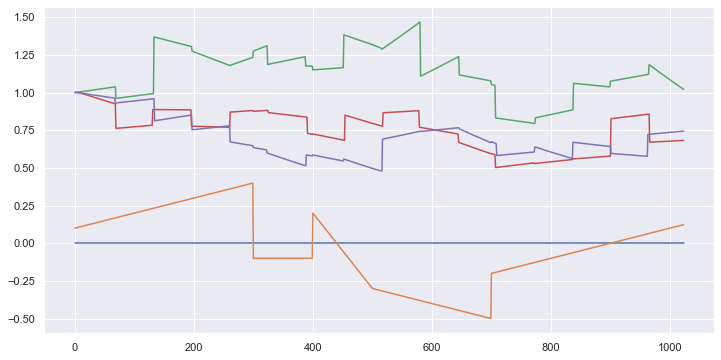

In [9]:
duration=1024
stocks = []
for ticker in tickers:
    E_cagr = np.random.normal(3e-2, 2e-2)   # expected compound annual growth rate
    max_effect = 3.0 # Maximum overrating due to sentiment
    psi0 = 50 + 20 * np.random.random() # initial price
    sentiments = rnd_sentiments()       # quarterly impacted stock sentiments
    beta_geo = np.random.normal(.0, .2)       # exposure (beta) to the US market
    stock = Stock(name=ticker, E_cagr=E_cagr, max_effect=max_effect, psi0 = psi0,
                    segments = {it: 1.0}, markets = {us: beta_geo},
                    sentiments = sentiments, noise=.4)
    stocks.append(stock)
#print(tickers)


plt.plot([it.phi(t) for t in range(duration)])
plt.plot([us.phi(t) for t in range(duration)])
plt.plot([stocks[0].psi(t)/stocks[0].psi(0) for t in range(duration)])
plt.plot([stocks[1].psi(t)/stocks[1].psi(0) for t in range(duration)])
plt.plot([stocks[2].psi(t)/stocks[2].psi(0) for t in range(duration)]);

#### Generating market history

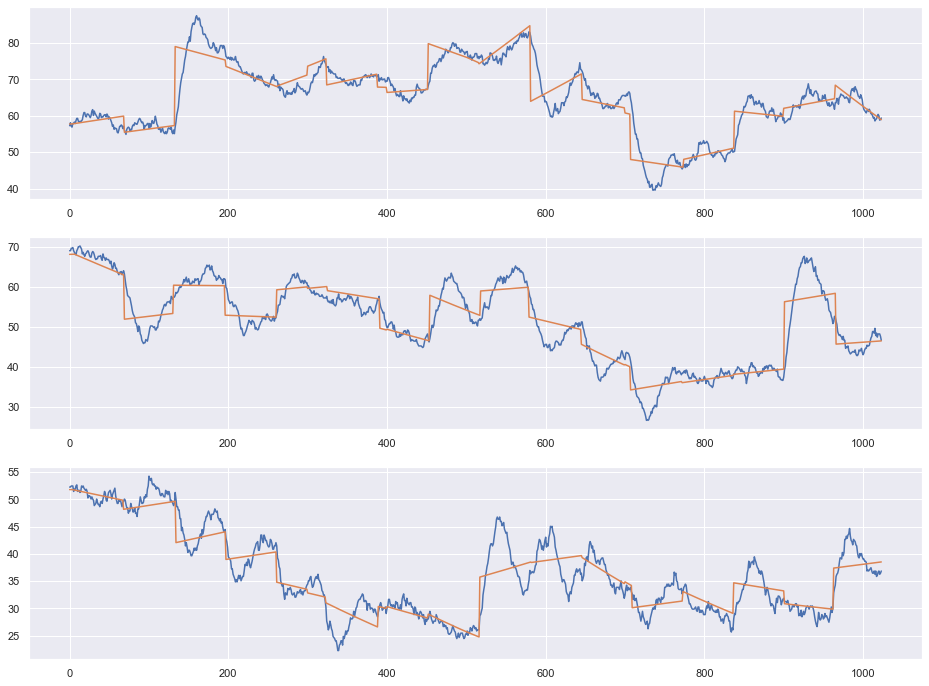

In [10]:
market = Market(stocks=stocks, bid_ask=0.1)

config = {
    'num_investors': 10,
    'num_rounds_per_day': 5
}

holdings = {ticker: 10000 for ticker in tickers}
holdings['cash'] = 1e7

environment = TradingEnvironment(config, holdings, market, tx_cost=2.5e-3)

for _ in range(1024):
    market.open()
    daily = environment.let_others_trade()
    market.close()

period = 1024
fig = plt.figure(figsize=(16,12))
u = fig.add_subplot(3, 1, 1)
m = fig.add_subplot(3, 1, 2)
l = fig.add_subplot(3, 1, 3)
for ticker in tickers[0:1]:
    rel_prices = np.array(market.history[ticker][:period])[:,1]
    u.plot(rel_prices);
    u.plot([stocks[0].psi(t) for t in range(period)]);
for ticker in tickers[1:2]:
    rel_prices = np.array(market.history[ticker][:period])[:,1]
    m.plot(rel_prices);
    m.plot([stocks[1].psi(t) for t in range(period)]);
for ticker in tickers[2:3]:
    rel_prices = np.array(market.history[ticker][:period])[:,1]
    l.plot(rel_prices);
    l.plot([stocks[2].psi(t) for t in range(period)]);


In [11]:
N_STOCKS = 5

In [12]:
tickers = list(set(["".join([chr(int(np.random.random()*26+65)) for i in range(4)]) 
                    for i in range(2*N_STOCKS)]))[:N_STOCKS]

In [13]:
def save_a_package():
    for i in range(1):
        period = 1152
        stocks = {}
        for ticker in tickers:
            E_cagr = np.random.normal(3e-2, 2e-2)   # expected compound annual growth rate
            max_effect = 3.0 # Maximum overrating due to sentiment
            psi0 = 50 + 20 * np.random.random() # initial price
            sentiments = rnd_sentiments()       # quarterly impacted stock sentiments
            beta_geo = np.random.normal(.0, .2)       # exposure (beta) to the US market
            stock = Stock(name=ticker, E_cagr=E_cagr, max_effect=max_effect, psi0 = psi0,
                            segments = {it: 1.0}, markets = {us: beta_geo},
                            sentiments = sentiments, noise=.4)
            stocks[ticker] = stock

        market = Market(stocks=list(stocks.values()), bid_ask=0.1)

        config = {
            'num_investors': 10,
            'num_rounds_per_day': 5
        }

        holdings = {ticker: 10000 for ticker in tickers}
        holdings['cash'] = 1e7

        environment = TradingEnvironment(config, holdings, market, tx_cost=2.5e-3)

        for _ in range(period):
            market.open()
            daily = environment.let_others_trade()
            market.close()

        package = [
            [np.array(market.history[ticker][:period])[:,1],
            [stocks[ticker].psi(t) for t in range(period)]]
            for ticker in tickers]

        with open('charts.pkl', 'ab') as file:
            pickle.dump(package, file)
            
#%time save_a_package()    

In [14]:
import pickle
from trading_model import MarketEnvironment, Observation, StockMarket

In [15]:
data = []
with open('charts.pkl', 'rb') as file:
    while True:
        try: 
            data.append(pickle.load(file))
        except EOFError:
            break;
data = np.array(data)
data = data[:,:,0,:] # drop the intrinsic value


In [16]:
class MarketFromData(StockMarket):
    """
    creates a market wrapper for an array or list of shape [N_STOCKS, N_PRICES]
    """
    def __init__(self, data, duration, nh, fee):
        """
        data: an array or list of shape [n_stocks, n_prices]
        nh: max. number of prices in history
        duration: the length of the period that can be served
        requires len(data) == duration + nh
        """
        self.duration = duration
        self.nh = nh
        self.data = np.array(data)
        self.n_securities = np.shape(self.data)[0]
        self.fee = fee
        length = np.shape(self.data)[1]
        if length != duration + nh:
            raise ValueError("record length not sum of duration and history.")
        # Need one more for the log returns
        np.append(self.data, self.data[:,-1:], axis = -1)
                    
    def log_return_history(self, nh, t):
        if t < 0 or t >= duration:
            raise ValueError("t must be between %s and %s" % (0, self.duration - 1))
        if nh > self.nh or nh <= 0:
            raise ValueError("t must be between %s and %s" % (1, self.nh))
        t += self.nh + 1
        
        h = self.data[ :, t-nh-1: t]
        return np.log(h[:, 1:] / h[:, :-1]).T
        
    def prices(self, t):
        return self.data[:, t]

In [17]:
np.shape(data[0])

(5, 1152)

In [18]:
market = MarketFromData(data[0], 1024, 128, fee=2.5e-3)

In [19]:
h = market.log_return_history(7, 0)
h

array([[-0.00371803, -0.0121736 , -0.01176432, -0.0158663 ,  0.        ],
       [-0.01880037, -0.00984672,  0.00589946, -0.00641768, -0.00964715],
       [-0.01529901, -0.01746856,  0.00878444,  0.00321399,  0.        ],
       [ 0.        ,  0.01746856,  0.00291108,  0.00958045,  0.00644176],
       [ 0.01529901, -0.0149543 ,  0.0201437 ,  0.01888987, -0.0129253 ],
       [ 0.02622266, -0.02029342,  0.01414391,  0.00311391,  0.00324702],
       [ 0.02194193,  0.00765837, -0.00563358, -0.00311391, -0.00650462]])

In [20]:
market.prices(0)

array([51.692, 67.046, 53.803, 66.928, 67.295])

In [21]:
env = MarketEnvironment(
    market = market, 
    return_scale = 100,
    weight_scale = .1,
    n_hist = 7, 
    portfolio = [4e5, 3e5, 3e5],
    t_init = 7)

In [22]:
n_history=16
t= 1000

In [23]:
env.step([.3, .2, .5])

[(array([[-0.00362372,  0.01263505, -0.01422438,  0.00931279,  0.        ],
       [ 0.01798868, -0.00756185,  0.00286111,  0.        , -0.01313756],
       [-0.00357194, -0.00507319, -0.00286111, -0.02502946,  0.00330061],
       [ 0.        , -0.01279673, -0.00863277,  0.00945962, -0.01326829],
       [-0.01441674, -0.01296262,  0.        , -0.01581611, -0.00334476],
       [-0.0036369 , -0.02912339, -0.00289423, -0.0128355 , -0.02373194],
       [ 0.01087125,  0.00802723, -0.00290263,  0.0128355 ,  0.01362999]]), array([0.4, 0.3, 0.3], dtype=float32)), array([0.3, 0.2, 0.5], dtype=float32), 0.003914975506034172, (array([[ 0.01798868, -0.00756185,  0.00286111,  0.        , -0.01313756],
       [-0.00357194, -0.00507319, -0.00286111, -0.02502946,  0.00330061],
       [ 0.        , -0.01279673, -0.00863277,  0.00945962, -0.01326829],
       [-0.01441674, -0.01296262,  0.        , -0.01581611, -0.00334476],
       [-0.0036369 , -0.02912339, -0.00289423, -0.0128355 , -0.02373194],
      

In [24]:
# Note that ```state()``` returns values scaled for training efficiency
env.state()

(array([[[[ 1.79886848],
          [-0.75618539],
          [ 0.28611095],
          [ 0.        ],
          [-1.31375566]],
 
         [[-0.35719426],
          [-0.50731915],
          [-0.28611095],
          [-2.50294633],
          [ 0.33006054]],
 
         [[ 0.        ],
          [-1.27967349],
          [-0.86327745],
          [ 0.94596152],
          [-1.32682932]],
 
         [[-1.44167422],
          [-1.29626164],
          [ 0.        ],
          [-1.58161075],
          [-0.33447644]],
 
         [[-0.36368966],
          [-2.91233883],
          [-0.28942324],
          [-1.2835499 ],
          [-2.37319384]],
 
         [[ 1.08712478],
          [ 0.80272285],
          [-0.29026333],
          [ 1.2835499 ],
          [ 1.36299921]],
 
         [[ 0.7182391 ],
          [ 1.06037099],
          [-1.46409069],
          [-1.60702822],
          [-1.36299921]]]]),
 array([[0.0299    , 0.02023861, 0.05015327]], dtype=float32))